<a href="https://colab.research.google.com/github/Abdullahfoysal/SelfDrivingCar/blob/master/Behavioural_Cloning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [223]:
!git clone https://github.com/Abdullahfoysal/car-training-data

fatal: destination path 'car-training-data' already exists and is not an empty directory.


In [224]:
!ls car-training-data 

driving_log.csv  IMG  README.md


In [225]:
!pip3 install imgaug



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [226]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D,MaxPooling2D,Dropout,Flatten,Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2 
import pandas as pd
import ntpath
import random

In [227]:
datadir = 'car-training-data'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir,"driving_log.csv"),names = columns)
pd.set_option('display.max_colwidth',-1)
data.head()

<ipython-input-227-a375477ff09d>:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth',-1)


center  \
0  /Users/foysalmac/Desktop/data/IMG/center_2023_01_09_18_27_27_213.jpg   
1  /Users/foysalmac/Desktop/data/IMG/center_2023_01_09_18_27_27_320.jpg   
2  /Users/foysalmac/Desktop/data/IMG/center_2023_01_09_18_27_27_433.jpg   
3  /Users/foysalmac/Desktop/data/IMG/center_2023_01_09_18_27_27_546.jpg   
4  /Users/foysalmac/Desktop/data/IMG/center_2023_01_09_18_27_27_659.jpg   

                                                                  left  \
0   /Users/foysalmac/Desktop/data/IMG/left_2023_01_09_18_27_27_213.jpg   
1   /Users/foysalmac/Desktop/data/IMG/left_2023_01_09_18_27_27_320.jpg   
2   /Users/foysalmac/Desktop/data/IMG/left_2023_01_09_18_27_27_433.jpg   
3   /Users/foysalmac/Desktop/data/IMG/left_2023_01_09_18_27_27_546.jpg   
4   /Users/foysalmac/Desktop/data/IMG/left_2023_01_09_18_27_27_659.jpg   

                                                                  right  \
0   /Users/foysalmac/Desktop/data/IMG/right_2023_01_09_18_27_27_213.jpg   
1   /Users/foysalmac/Desktop/data/IMG/right_2023_01_09_18_27_27_320.jpg   
2   /Users/foysalmac/Desktop/data/IMG/right_2023_01_09_18_27_27_433.jpg   
3   /Users/foysalmac/Desktop/data/IMG/right_2023_01_09_18_27_27_546.jpg   
4   /Users/foysalmac/Desktop/data/IMG/right_2023_01_09_18_27_27_659.jpg   

   steering  throttle  reverse     speed  
0  0.0       0.0       0        0.000078  
1  0.0       0.0       0        0.000078  
2  0.0       0.0       0        0.000080  
3  0.0       0.0       0        0.000079  
4  0.0       0.0       0        0.000078

In [228]:
def path_leaf(path):
  head,tail = ntpath.split(path)
  return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center                              left  \
0  center_2023_01_09_18_27_27_213.jpg  left_2023_01_09_18_27_27_213.jpg   
1  center_2023_01_09_18_27_27_320.jpg  left_2023_01_09_18_27_27_320.jpg   
2  center_2023_01_09_18_27_27_433.jpg  left_2023_01_09_18_27_27_433.jpg   
3  center_2023_01_09_18_27_27_546.jpg  left_2023_01_09_18_27_27_546.jpg   
4  center_2023_01_09_18_27_27_659.jpg  left_2023_01_09_18_27_27_659.jpg   

                               right  steering  throttle  reverse     speed  
0  right_2023_01_09_18_27_27_213.jpg  0.0       0.0       0        0.000078  
1  right_2023_01_09_18_27_27_320.jpg  0.0       0.0       0        0.000078  
2  right_2023_01_09_18_27_27_433.jpg  0.0       0.0       0        0.000080  
3  right_2023_01_09_18_27_27_546.jpg  0.0       0.0       0        0.000079  
4  right_2023_01_09_18_27_27_659.jpg  0.0       0.0       0        0.000078

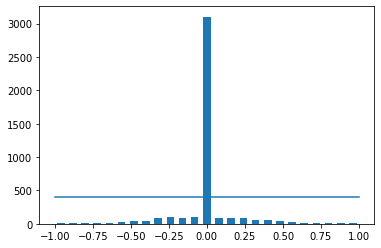

In [229]:
num_bins = 25
samples_per_bin = 400
hist,bins = np.histogram(data['steering'],num_bins)

center = (bins[:-1]+bins[1:]) *0.5

plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

total data:  4124
removed:  2702
remaining:  1422


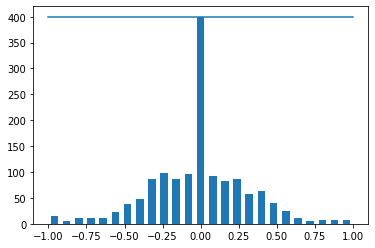

In [230]:
print('total data: ',len(data))
remove_list = []
for j in range(num_bins):
  list_ =[]
  for i in range(len(data['steering'])):
   if ((data['steering'][i] >= bins[j]) and (data['steering'][i] <= bins[j+1])):
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print("removed: ",len(remove_list))
data.drop(data.index[remove_list],inplace=True)
print('remaining: ',len(data))

hist,_ =np.histogram(data['steering'],(num_bins))
plt.bar(center,hist,width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])),(samples_per_bin,samples_per_bin))

In [231]:
print(data.iloc[1])
def load_img_steering(datadir,df):
  image_path =[]
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center,left,right = indexed_data[0],indexed_data[1],indexed_data[2]
    image_path.append(os.path.join(datadir,center.strip()))
    steering.append(indexed_data[3])
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings 

image_paths, steerings = load_img_steering(datadir+'/IMG',data)






center      center_2023_01_09_18_27_30_182.jpg
left        left_2023_01_09_18_27_30_182.jpg  
right       right_2023_01_09_18_27_30_182.jpg 
steering   -0.189336                          
throttle    1.0                               
reverse     0                                 
speed       12.33081                          
Name: 26, dtype: object


In [232]:
X_train, X_valid,y_train,y_valid = train_test_split(image_paths,steerings,test_size = 0.2,random_state = 6)
print('Training samples: {}\nValid Samples: {}'.format(len(X_train),len(X_valid)))

Training samples: 1137
Valid Samples: 285


Text(0.5, 1.0, 'Valid set')

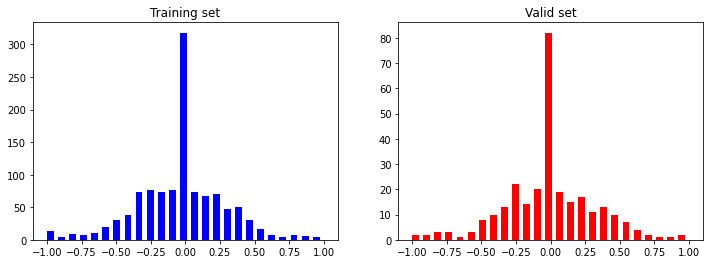

In [233]:
fig,axes = plt.subplots(1,2,figsize=(12,4))
axes[0].hist(y_train,bins=num_bins,width=0.05,color='blue')
axes[0].set_title("Training set")
axes[1].hist(y_valid,bins=num_bins,width=0.05,color='red')
axes[1].set_title("Valid set")

In [234]:
def zoom(image):
  zoom = iaa.Affine(scale=(1,1.3))
  image = zoom.augment_image(image)
  return image


Text(0.5, 1.0, 'Zoomed image')

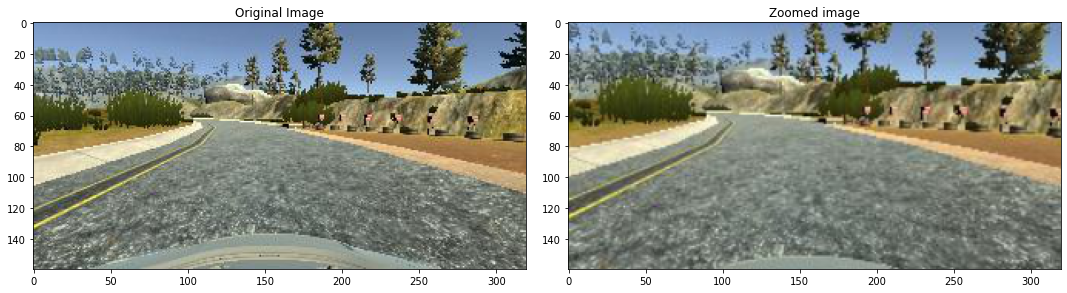

In [235]:
image =image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig,axs =plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("Original Image")
axs[1].imshow(zoomed_image)
axs[1].set_title("Zoomed image")

In [236]:
def pan(image):
  pan = iaa.Affine(translate_percent={"x":(-0.1,0.1),"y":(-0.1,0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1.0, 'Panned image')

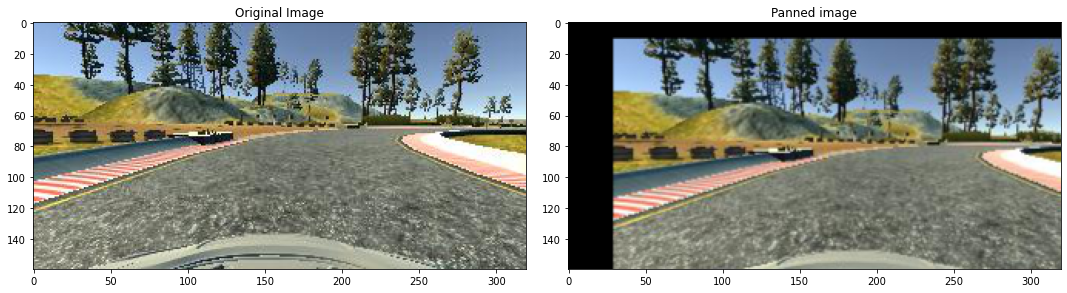

In [237]:
image =image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig,axs =plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("Original Image")
axs[1].imshow(panned_image)
axs[1].set_title("Panned image")

In [238]:
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2,1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1.0, 'brightness_altered_image')

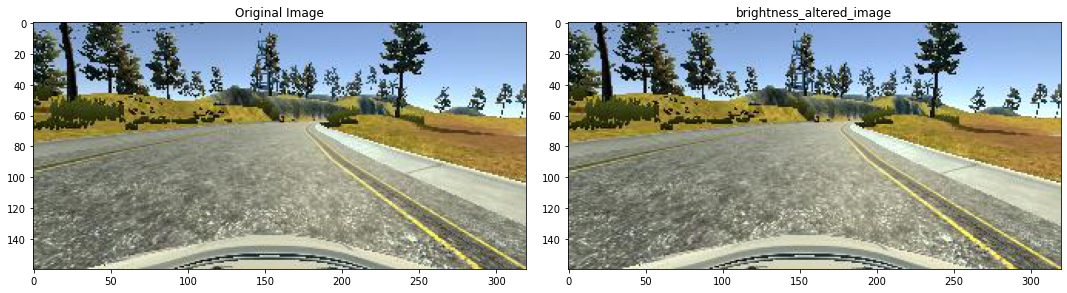

In [239]:
image =image_paths[random.randint(0,1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig,axs =plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("Original Image")
axs[1].imshow(brightness_altered_image)
axs[1].set_title("brightness_altered_image")

In [240]:
def img_random_flip(image,steering_angle):
  image =cv2.flip(image,1)
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1.0, 'flipped_image Steering Angle: -0.1558979')

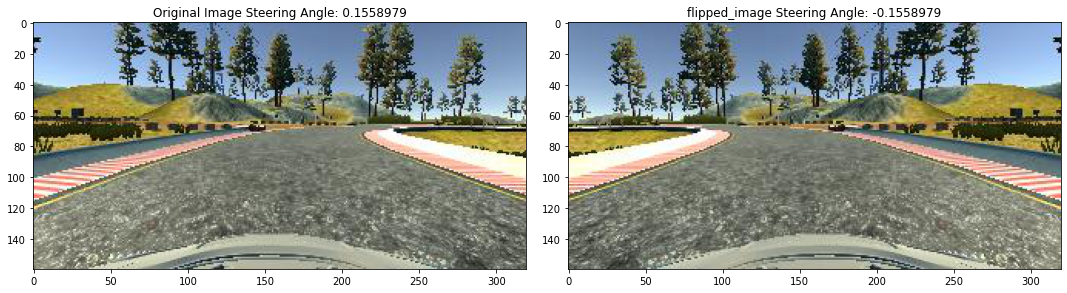

In [241]:
random_index = random.randint(0,1000)
image =image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle  = img_random_flip(original_image,steering_angle)

fig,axs =plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("Original Image "+"Steering Angle: "+str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title("flipped_image "+'Steering Angle: '+str(flipped_steering_angle))

In [242]:
def random_augment(image,steering_angle):
  image = mpimg.imread(image)
  if np.random.rand()<0.5:
    image = pan(image)
  if np.random.rand()<0.5:
    image = zoom(image)
  if np.random.rand()<0.5:
    image = img_random_brightness(image)
  if np.random.rand()<0.5:
    image, steering_angle = img_random_flip(image,steering_angle)
  return image, steering_angle

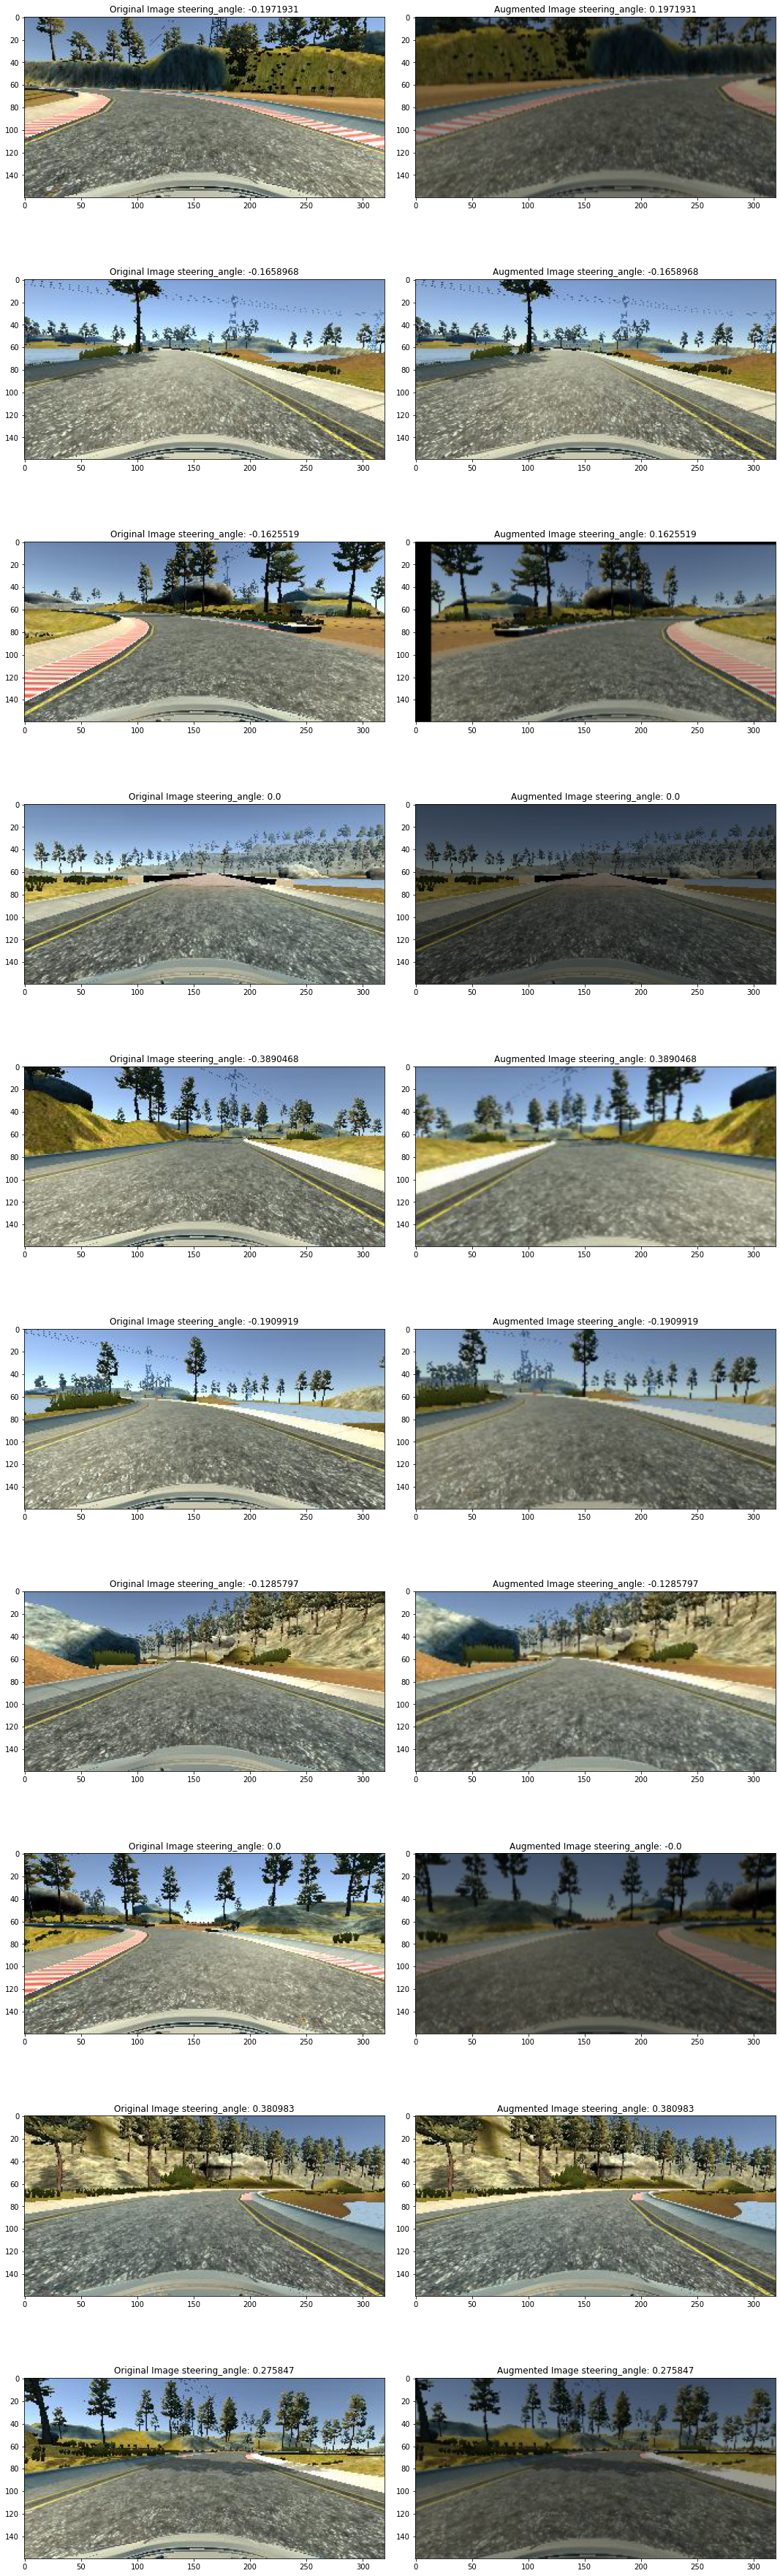

In [243]:
ncol = 2
nrow =10
fig,axs = plt.subplots(nrow,ncol,figsize=(15,50))
fig.tight_layout()

for i in range(10):
  randnum = random.randint(0,len(image_paths)-1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]
  
  original_image = mpimg.imread(random_image)
  augmented_image, steering =random_augment(random_image,random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title("Original Image "+'steering_angle: '+str(random_steering))

  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title("Augmented Image "+"steering_angle: "+str(steering))




In [244]:
def img_preprocess(img):
  img = img[60:135, :,:]
  img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img,(3,3),0)
  img = cv2.resize(img,(200,66))
  img =img/255

  return img

In [245]:
def batch_generator(image_paths,steering_ang,batch_size,istraining):
   while True:
     batch_img = []
     batch_steering =[]

     for i in range(batch_size):
       random_index = random.randint(0,len(image_paths)-1)

       if istraining:
         im,steering = random_augment(image_paths[random_index],steering_ang[random_index])
       
       else:
          im = mpimg.imread(image_paths[random_index])
          steering = steering_ang[random_index]
        
       im = img_preprocess(im)
       batch_img.append(im)
       batch_steering.append(steering)
     yield (np.asarray(batch_img),np.asarray(batch_steering))




Text(0.5, 1.0, 'validation Image ')

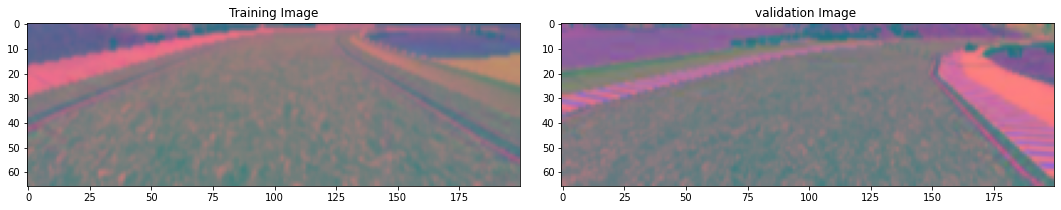

In [246]:
x_train_gen,y_train_gen = next(batch_generator(X_train,y_train,1,1))
x_valid_gen,y_valid_gen = next(batch_generator(X_valid,y_valid,1,0))

fig,axs =plt.subplots(1,2,figsize=(15,10))
fig.tight_layout()
axs[0].imshow(x_train_gen[0])
axs[0].set_title("Training Image")
axs[1].imshow(x_valid_gen[0])
axs[1].set_title("validation Image ")

Text(0.5, 1.0, 'Preprocessed Image')

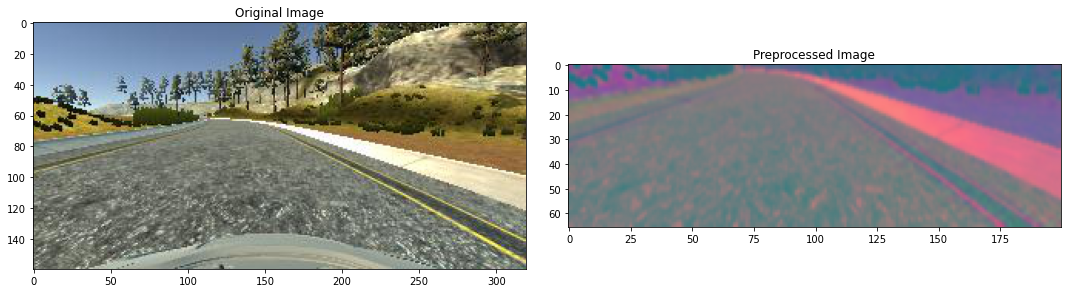

In [247]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig,axs = plt.subplots(1,2,figsize =(15,10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title("Original Image")
axs[1].imshow(preprocessed_image)
axs[1].set_title("Preprocessed Image")

In [248]:
#X_train = np.array(list(map(img_preprocess,X_train)))
#X_valid = np.array(list(map(img_preprocess,X_valid)))

In [249]:
# plt.imshow(X_train[random.randint(0,len(X_train)-1)])
# print(X_train.shape)

In [250]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24,(5,5),strides =(2,2),input_shape =(66,200,3),activation ='elu' ))
  model.add(Convolution2D(36,(5,5),strides=(2,2),activation='elu'))
  model.add(Convolution2D(48,(5,5),strides=(2,2),activation='elu'))
  model.add(Convolution2D(64,(3,3), activation='elu'))
  model.add(Convolution2D(64,(3,3),activation='elu'))
  #model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(100,activation='elu'))
  #model.add(Dropout(0.5))

  model.add(Dense(50,activation='elu'))
 # model.add(Dropout(0.5))

  model.add(Dense(10,activation='elu'))
 # model.add(Dropout(0.5))

  model.add(Dense(1))
  optimizer = Adam(learning_rate=1e-4)
  model.compile(optimizer,loss='mse')
  return model


In [251]:
model = nvidia_model()
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_21 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_22 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_23 (Conv2D)          (None, 3, 20, 64)         27712     
                                                                 
 conv2d_24 (Conv2D)          (None, 1, 18, 64)         36928     
                                                                 
 flatten_4 (Flatten)         (None, 1152)              0         
                                                                 
 dense_16 (Dense)            (None, 100)              

In [252]:
history = model.fit_generator(batch_generator(X_train,y_train,100,1),
                              steps_per_epoch =30,
                              epochs =5,
                              validation_data = batch_generator(X_valid,y_valid,100,0),
                              validation_steps = 20,
                              verbose =1,
                              shuffle =True)

<ipython-input-252-5494a8660cf6>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(batch_generator(X_train,y_train,100,1),


Epoch 1/5
30/30 [==============================] - 23s 745ms/step - loss: 0.1147 - val_loss: 0.1010
Epoch 2/5
30/30 [==============================] - 13s 457ms/step - loss: 0.0935 - val_loss: 0.0866
Epoch 3/5
30/30 [==============================] - 13s 456ms/step - loss: 0.0881 - val_loss: 0.0740
Epoch 4/5
30/30 [==============================] - 13s 461ms/step - loss: 0.0917 - val_loss: 0.0710
Epoch 5/5
30/30 [==============================] - 13s 454ms/step - loss: 0.0842 - val_loss: 0.0679


Text(0.5, 0, 'epoch')

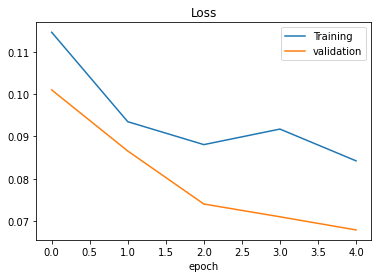

In [253]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training','validation'])
plt.title("Loss")
plt.xlabel("epoch")

In [254]:
model.save('model.h5')

In [255]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>